[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NazariAmin/ML-Project/blob/master/MobileNet.ipynb)

In [6]:
ls

sample_data/


In [7]:
%cd
!git clone https://github.com/tensorflow/models.git

/root
Cloning into 'models'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 22162 (delta 0), reused 0 (delta 0), pack-reused 22155
Receiving objects: 100% (22162/22162), 559.71 MiB | 29.62 MiB/s, done.
Resolving deltas: 100% (13079/13079), done.
Checking out files: 100% (2828/2828), done.


In [8]:
ls

models/


In [0]:
%cd models/research/deeplab/
#!sh ./local_test.sh

model_dir = '/content/models/research/deeplab/datasets/pascal_voc_seg/exp/train_on_trainval_set/export/'

In [9]:
%cd models/research/deeplab/
!sh ./local_test_mobilenetv2.sh

model_dir = '/content/models/research/deeplab/datasets/pascal_voc_seg/exp/train_on_trainval_set_mobilenetv2/export/'


/root/models/research/deeplab
testBuildDeepLabWithDensePredictionCell (__main__.DeeplabModelTest) ... 2018-10-18 10:12:05.685241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-10-18 10:12:05.685802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1411] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-10-18 10:12:05.685846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1490] Adding visible gpu devices: 0
2018-10-18 10:12:06.139895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:971] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-10-18 10:12:06.139978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977]      0 
2018-10-18 10:12:06.140007: I tensorflow/core/common_runtime/gpu/gpu_device.

In [0]:
model_dir = '/content/models/research/deeplab/datasets/pascal_voc_seg/exp/train_on_trainval_set_mobilenetv2/export/'

In [9]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import gridspec

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'Pedestrian', 'boat', 'sidewalk', 'bus',
    'car', 'fence', 'chair', 'road', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pole', 'tree', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
print('successfully finsihed !')

successfully finsihed !


In [0]:
model_dir = '/root/models/research/deeplab/datasets/pascal_voc_seg/exp/train_on_trainval_set_mobilenetv2/export/'


In [0]:
import os
import tarfile

_MODEL_NAME = 'frozen_inference_graph.pb'
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_path = os.path.join(model_dir, _MODEL_NAME)
download_path = os.path.join(model_dir, _TARBALL_NAME)
with tarfile.open(download_path, "w:gz") as tar:
        tar.add(model_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

In [18]:
ls

/root/models/research/deeplab/datasets


Saving 82.jpg to 82.jpg
saved file 82.jpg


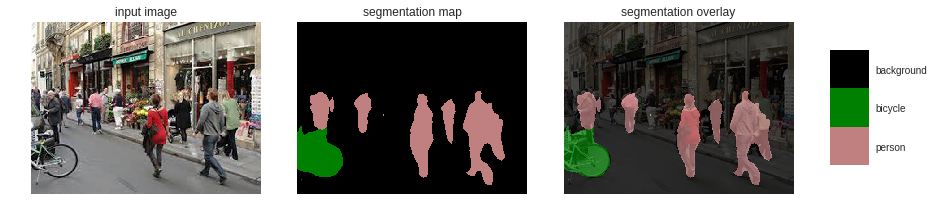

In [37]:
from google.colab import files
from os import path
from PIL import Image

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('img.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
    
im = Image.open(name)
resized_im, seg_map = MODEL.run(im)

vis_segmentation(resized_im, seg_map)

In [1]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-10-18 14:16:19--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.84.34, 52.73.9.93, 52.54.84.112, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.84.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.71MB/s    in 0.7s    

2018-10-18 14:16:20 (7.71 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [5]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://2cc7f502.ngrok.io


In [0]:
ls